# LSTM-GloVe Model for Sentiment Analysis in text data

En este notebook se describe el proceso de carga, preprocesamiento, embedding, construcción y entrenamiento de un modelo que emplea LSTM y GloVe
para el set de datos de texto.

## Carga de Datos

A continuación se cargará el dataset unificado que se construyó en etapas anteriores (Ver `data_join.ipynb` y `NLP_tasks.ipynb`) que cuenta con cas 66000 registros de texto.

In [1]:
import pandas as pd
data = pd.read_csv('../../data/text/cleaned/final.csv', nrows=1000000)
data.head()

,text,priority,tweet
0,@amirulmokhtar Exactly! We were busy buat untu...,1,NaN
1,Ternangis baca text &amp; dengar call reply di...,1,NaN
2,I learn smthg very valuable today.\n\nWhen I w...,1,NaN
3,"@MintKr Ohhh okay. So, to create more opportun...",1,NaN
4,@MintKr Perspective expanding experience tu ap...,1,NaN


In [2]:
data.drop(columns=['tweet'], inplace=True)
data.shape

(1000000, 2)

## Preprocesamiento

### Texto

Es necesario remover de nuestros datos información irrelevante como etiquetas, puntución, números y caracteres especiales.

In [3]:
import re
data['text'][0]

'@amirulmokhtar Exactly! We were busy buat untuk orang, brand sendiri tak buat-buat🤣'

In [4]:
TAG_RE = re.compile(r'@[^> ]+')

def remove_at_sign(sentence: str):
    '''
    Replaces '@' from and input string for an empty space
    :param sentence: String that contains @
    :return: sentence without @
    '''

    return TAG_RE.sub('', sentence)

In [5]:
remove_at_sign(data['text'][0])

' Exactly! We were busy buat untuk orang, brand sendiri tak buat-buat🤣'

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords

def preprocess_text(sentence: str):
    '''
    Cleans up a sentence leaving only 2 or more non-stopsentences composed of upper and lowercase
    :param sentence: String to be cleaned
    :return: sentence without numbers, special chars and long stopsentences
    '''

    cleaned_sentence = sentence.lower()
    cleaned_sentence = remove_at_sign(cleaned_sentence)
    cleaned_sentence = re.sub('[^a-zA-Z]', ' ', cleaned_sentence)
    cleaned_sentence = re.sub('\s+[a-zA-Z]\s', ' ', cleaned_sentence)
    cleaned_sentence = re.sub('\s+', ' ', cleaned_sentence)

    #Removal of stopsentences
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s')
    cleaned_sentence = pattern.sub('', cleaned_sentence)

    return cleaned_sentence

In [8]:
preprocess_text(data['text'][0])

' exactly busy buat untuk orang brand sendiri tak buat buat '

In [9]:
from copy import  deepcopy

data['text'] = data['text'].apply(preprocess_text)
data['text']

0          exactly busy buat untuk orang brand sendiri t...
1         ternangis baca text amp dengar call reply dieo...
2         learn smthg valuable today honest condition cl...
3          ohhh okay create opportunities things engagin...
4             perspective expanding experience tu apa mint 
                                ...                        
999995     saw first part notifications thought still aw...
999996                                     fingers crossed 
999997     stream games know minecraft back spotlight ga...
999998                              random gets paulharris 
999999                                  done notifications 
Name: text, Length: 1000000, dtype: object

## Embedding

Para el proceso de embedding se usarán los datos de un modelo de embedding como lo es GloVe.
La información dicho modelo será cargada dentro de `words`. Cada uno de los tokens de GloVe que
se usará tiene una dimensión de 50. En caso de que

In [10]:
import numpy as np

words = {}

def add_to_dict(dictionary, filename):
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')

            try:
                dictionary[line[0]] = np.array(line[1:], dtype=float)
            except:
                continue

add_to_dict(words, './GloVe/glove.6B/glove.6B.50d.txt')

In [11]:
# words

### Tokenización y Lematización

Una vez cargada la información de los tokens de GloVe se procede a tokenizar y lematizar cada
una de las oraciones en nuestro set de datos.

In [12]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Ejemplo de cómo se debería de tokenizar y lematizar una oración:

In [13]:
from nltk import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()

sample = preprocess_text(data['text'][0])
token_sample = tokenizer.tokenize(sample)
lemma_sample = [lemmatizer.lemmatize(token) for token in token_sample]
lemma_sample

['exactly',
 'busy',
 'buat',
 'untuk',
 'orang',
 'brand',
 'sendiri',
 'tak',
 'buat',
 'buat']

A continuación se define una función para la tokenización y lematización. Adicionalmente, el token final que se entrega únicamente contiene palabras definidas en `words`.

In [14]:
def sentence_to_token_list(sentence: str):
    tokens = tokenizer.tokenize(sentence)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    useful_tokens = [token for token in lemmatized_tokens if token in words]

    return  useful_tokens

In [15]:
sentence_to_token_list(sample)

['exactly', 'busy', 'buat', 'untuk', 'orang', 'brand', 'tak', 'buat', 'buat']

Con el token anterior, el cual sabemos se puede representar por medio de uno de los tokens almacenados en `words`, entonces pasamos a la representación de estos:

In [16]:
def sentence_to_words_vectors(sentence: str, word_dict=words):
    processed_tokens = sentence_to_token_list(sentence)

    vectors = []
    for token in processed_tokens:
        if token in word_dict:
            token_vector = word_dict[token]
            vectors.append(token_vector)

    return np.array(vectors, dtype=float)

In [17]:
sentence_to_words_vectors(sample).shape

(9, 50)

In [18]:
sentence_to_words_vectors(sample)

array([[ 6.5231e-01,  1.4335e-01,  4.0117e-01, -1.6664e-01,  1.1595e+00,
        -5.5514e-02, -5.5901e-03,  1.5662e-02, -6.2604e-01,  1.0004e-01,
        -3.0654e-01, -8.4817e-02, -3.6174e-01,  4.4437e-02,  1.0036e+00,
         4.4135e-01,  1.6649e-01, -1.0938e-01, -3.1330e-01, -7.8070e-01,
        -2.7446e-01,  1.9791e-01,  5.8306e-01,  2.6347e-01,  9.1289e-01,
        -1.1172e+00, -9.5494e-01,  3.0935e-01,  9.2042e-01, -5.9419e-01,
         2.5015e+00,  4.6936e-02, -4.6372e-01, -6.4048e-01,  2.1563e-01,
        -4.6015e-01,  3.3687e-01,  2.8244e-01,  8.0691e-02, -4.5496e-02,
        -2.3991e-01, -1.2775e-01,  3.1299e-02,  5.1838e-01, -4.4902e-01,
         1.6894e-01,  3.9250e-01,  3.3941e-01,  6.5578e-02,  6.1038e-01],
       [ 6.3611e-01, -2.0268e-01, -1.6311e-01, -5.8643e-01, -8.2231e-03,
        -9.6940e-01, -1.1178e+00,  3.4615e-01,  2.2185e-01, -2.8930e-01,
        -1.0362e+00, -5.2713e-01, -6.0557e-01,  4.2990e-01,  1.6935e-02,
        -9.3337e-02, -4.8383e-02,  5.2209e-01,  2.

In [19]:
#Se obtiene nuestro conjunto de datos X
X = data['text'].apply(lambda sentence: sentence_to_words_vectors(sentence))

Dado que las matrices de vectores de cada oración tienen un número diferente de filas debido a que cada oración cuenta con un número diferente de palabas. Es necesario identificar el tamaño máximo de los textos que se tienen para su "estandarización":

In [20]:
temporal = deepcopy(X)
temporal['len'] = temporal.apply(np.shape)

MAX_LEN = max(temporal['len'])[0]
del temporal
MAX_LEN

112

Dado que el tamaño máximo es 112, entonces se llevarán todas las matrices a la forma `(35, 50)`. Los valores faltantes para cada vector serán 0s en su inicio.

In [21]:
import tensorflow as tf

X = tf.keras.utils.pad_sequences(X, maxlen=MAX_LEN, dtype='float16')

In [22]:
X.shape

(1000000, 112, 50)

In [23]:
X[0].shape

(112, 50)

In [24]:
X[0]

array([[ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     , ...,  0.     ,  0.     ,  0.     ],
       ...,
       [-0.01334, -0.4185 ,  0.5586 , ..., -0.333  ,  1.173  ,  0.3745 ],
       [ 0.2396 , -0.784  ,  0.324  , ...,  0.418  ,  1.16   ,  0.7188 ],
       [ 0.2396 , -0.784  ,  0.324  , ...,  0.418  ,  1.16   ,  0.7188 ]],
      dtype=float16)

## División Entrenamiento-Validación-Test

In [25]:
y = data['priority']
del data

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=3)

MemoryError: Unable to allocate 3.13 GiB for an array with shape (300000, 112, 50) and data type float16

# Modelos

In [28]:
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, Lambda, LSTM, Flatten, Dense, Input, Dropout, Bidirectional, GlobalMaxPooling1D
from keras.optimizers import Adam, RMSprop, SGD
from kerastuner import RandomSearch, HyperParameters
from keras.layers import Conv1D, MaxPooling1D

def print_hyperparameters(json_data):
    values = json_data["values"]
    
    for key, value in sorted(values.items()):
        print(f"{key}: {value}")

/tmp/ipykernel_17641/2019262015.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch, HyperParameters


In [29]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)
cp = ModelCheckpoint('saved/', save_best_only=True)

callbacks = [cp, early_stopping, reduce_lr]

## GloVe-LSTM

In [30]:


def build_model(hp):
    
    model = Sequential()
    model.add(Input(shape=(MAX_LEN, 50)))

    # Hiperparámetros para LSTM 1
    lstm_units = hp.Int("lstm_units_1", min_value=128, max_value=256, step=32)
    lstm_dropout = hp.Float("lstm_dropout", min_value=0.1, max_value=0.5, step=0.1)
    
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=lstm_dropout)))

    # Hiperparámetros para LSTM 2
    lstm_units = hp.Int("lstm_units_2", min_value=64, max_value=128, step=32)
    lstm_dropout = hp.Float("lstm_dropout_2", min_value=0.1, max_value=0.5, step=0.1)
    
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=lstm_dropout, recurrent_dropout=lstm_dropout)))
    model.add(GlobalMaxPooling1D())

    # Hiperparámetros para capa densa 1
    dense_units = hp.Int("dense_units_1", min_value=32, max_value=128, step=32)
    dense_dropout = hp.Float("dense_dropout_1", min_value=0.1, max_value=0.5, step=0.1)
    
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dense_dropout))

    # Hiperparámetros para capa densa 2
    dense_units = hp.Int("dense_units_2", min_value=32, max_value=128, step=32)
    model.add(Dense(dense_units, activation='relu'))

    # Salida del modelo
    model.add(Dense(7, activation='softmax'))

    # Hiperparámetros para el optimizador (En otras pruebas se vio que Adam era el mejor)
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="LOG")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define el objeto de búsqueda aleatoria
tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=20,  # Número de modelos a probar
    executions_per_trial=1,
    directory='./saved/fine_tuned/',
    project_name='HP_LSTM_Glove_text'
)

# Resumen de la búsqueda
tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from ./saved/fine_tuned/HP_LSTM_Glove_text/tuner0.json
Search space summary
Default search space size: 8
lstm_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
lstm_dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lstm_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
lstm_dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dense_dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 

In [31]:
BATCH_SIZE=1024
tuner.search(X_train, y_train,
                    epochs=10,
                    validation_split=0.1,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)



INFO:tensorflow:Oracle triggered exit


In [32]:
best_hp_gloveLstm = tuner.get_best_hyperparameters()[0]

print("Mejores hiperparámetros encontrados:")
print(best_hp_gloveLstm.get_config())


Mejores hiperparámetros encontrados:
{'space': [{'class_name': 'Int', 'config': {'name': 'lstm_units_1', 'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'lstm_dropout', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'lstm_units_2', 'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'lstm_dropout_2', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'dense_units_1', 'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dense_dropout_1', 'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 

In [33]:
# from keras.models import Sequential
# from keras.layers import Embedding, LSTM, Flatten, Dense, Input, Dropout, Bidirectional, GlobalMaxPooling1D

# model = Sequential()
# model.add(Input(shape=(MAX_LEN, 50)))
# model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)))
# model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.25, recurrent_dropout=0.25)))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(7, activation='softmax'))

## Test

In [34]:
from keras.models import load_model

lstm_basic_model = load_model('saved/')

2023-05-02 11:59:29.950888: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:59:29.951076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:59:29.959918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:59:29.960095: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-02 11:59:29.960244: I tensorflow/compiler/xla/stream_executo

In [35]:
score = lstm_basic_model.evaluate(X_test, y_test, verbose=1)

  5/413 [..............................] - ETA: 12s - loss: 1.3132 - accuracy: 0.4375

2023-05-02 11:59:36.371396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


413/413 [==============================] - 15s 33ms/step - loss: 1.3025 - accuracy: 0.5127


In [36]:
print('Test Accuracy:', score[1])

Test Accuracy: 0.5126534104347229


## GloVe-LSTM-DO

In [37]:
lstm_dropout_dense = Sequential(name='Lstm-dout-dense')
lstm_dropout_dense.add(Input(shape=(MAX_LEN, 50)))
lstm_dropout_dense.add(LSTM(64, return_sequences=True))
lstm_dropout_dense.add(Dropout(0.2))
lstm_dropout_dense.add(LSTM(32))
lstm_dropout_dense.add(Flatten())
lstm_dropout_dense.add(Dense(128, activation='relu'))
lstm_dropout_dense.add(Dense(7, activation='softmax'))

In [38]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Flatten, Dense
from keras.optimizers import Adam, RMSprop, SGD
from kerastuner import RandomSearch, HyperParameters

def build_model_gloveLstmDo(hp):
    model = Sequential(name='GloVe-LSTM-DO')
    model.add(Input(shape=(MAX_LEN, 50)))
    
    # Hiperparámetros para la primera capa LSTM
    lstm_units_1 = hp.Int("lstm_units_1", min_value=32, max_value=128, step=32)
    model.add(LSTM(lstm_units_1, return_sequences=True))
    
    # Hiperparámetros para Dropout
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))
    
    # Hiperparámetros para la segunda capa LSTM
    lstm_units_2 = hp.Int("lstm_units_2", min_value=16, max_value=64, step=16)
    model.add(LSTM(lstm_units_2))
    
    model.add(Flatten())
    
    # Hiperparámetros para la capa Densa
    dense_units = hp.Int("dense_units", min_value=32, max_value=256, step=32)
    model.add(Dense(dense_units, activation='relu'))
    
    model.add(Dense(7, activation='softmax'))

    # Hiperparámetros para el optimizador
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="LOG")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

gloveLstmDoTuner = RandomSearch(
    build_model_gloveLstmDo,
    objective="val_accuracy",
    max_trials=20,  # Número de modelos a probar
    executions_per_trial=1,
    directory='./saved/fine_tuned/',
    project_name='HP_LSTM_dropout_dense'
)

# Resumen de la búsqueda
gloveLstmDoTuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from ./saved/fine_tuned/HP_LSTM_dropout_dense/tuner0.json
Search space summary
Default search space size: 5
lstm_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lstm_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}


In [39]:
# Realiza la búsqueda
gloveLstmDoTuner.search(X_train, y_train,
             epochs=10,
             validation_split=0.1,
             batch_size=4096,
             callbacks=callbacks)

best_hp_gloveLstmDo = gloveLstmDoTuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Oracle triggered exit


In [40]:
# lstm_dropout_dense.summary()

In [41]:
# lstm_dropout_dense.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['acc'])

In [42]:
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [43]:
# history_2 = lstm_dropout_dense.fit(X_train, y_train,
#                     validation_split=0.2, epochs=10,
#                     batch_size=BATCH_SIZE,
#                     callbacks=[early_stop])

In [44]:
# score = lstm_dropout_dense.evaluate(X_test, y_test, verbose=1)
# print('Test Accuracy:', score[1])

# 3LSTM-DO-CNN-Dense

In [45]:
# from keras.layers import Conv1D, MaxPooling1D
# from keras.models import Sequential
# from keras.layers import Input, LSTM, Dropout, Flatten, Dense
# from keras.optimizers import Adam, RMSprop, SGD
# from kerastuner import RandomSearch, HyperParameters

# lstm3_do_cnn_dense = Sequential(name='3LSTM-DO-CNN-Dense')
# lstm3_do_cnn_dense.add(Input(shape=(MAX_LEN, 50)))

# #LSTM
# lstm3_do_cnn_dense.add(LSTM(256, name='LSTM1', return_sequences=True))
# lstm3_do_cnn_dense.add(Dropout(0.2, name='DO1'))

# lstm3_do_cnn_dense.add(LSTM(128, name='LSTM2', return_sequences=True))
# lstm3_do_cnn_dense.add(Dropout(0.2, name='DO2'))

# lstm3_do_cnn_dense.add(LSTM(64, name='LSTM3', return_sequences=True))
# lstm3_do_cnn_dense.add(Dropout(0.2, name='DO3'))

# #CNN
# lstm3_do_cnn_dense.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
# lstm3_do_cnn_dense.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
# lstm3_do_cnn_dense.add(Dropout(0.2))
# lstm3_do_cnn_dense.add(Flatten(name='F1'))

# #Fully connected
# lstm3_do_cnn_dense.add(Dense(64, activation='relu'))
# lstm3_do_cnn_dense.add(Dense(7, activation='softmax'))

# lstm3_do_cnn_dense.summary()

In [46]:
def build_model_gloveLstmDoCnn(hp):
    model = Sequential(name='3LSTM-DO-CNN-Dense')
    model.add(Input(shape=(MAX_LEN, 50)))

    # Hiperparámetros para la primera capa LSTM
    lstm_units_1 = hp.Int("lstm_units_1", min_value=128, max_value=512, step=32)
    model.add(LSTM(lstm_units_1, name='LSTM1', return_sequences=True))
    lstm_dropout_1 = hp.Float("lstm_dropout_1", min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(lstm_dropout_1, name='DO1'))

    # Hiperparámetros para la segunda capa LSTM
    lstm_units_2 = hp.Int("lstm_units_2", min_value=64, max_value=256, step=32)
    model.add(LSTM(lstm_units_2, name='LSTM2', return_sequences=True))
    lstm_dropout_2 = hp.Float("lstm_dropout_2", min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(lstm_dropout_2, name='DO2'))

    # Hiperparámetros para la tercera capa LSTM
    lstm_units_3 = hp.Int("lstm_units_3", min_value=32, max_value=128, step=16)
    model.add(LSTM(lstm_units_3, name='LSTM3', return_sequences=True))
    lstm_dropout_3 = hp.Float("lstm_dropout_3", min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(lstm_dropout_3, name='DO3'))

    # Hiperparámetros para la capa Conv1D
    conv_filters = hp.Int("conv_filters", min_value=32, max_value=256, step=32)
    model.add(Conv1D(conv_filters, kernel_size=3, strides=1, padding='same', activation='relu'))
    
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    cnn_dropout = hp.Float("cnn_dropout", min_value=0.1, max_value=0.5, step=0.1)
    model.add(Dropout(cnn_dropout))
    
    model.add(Flatten(name='F1'))

    # Hiperparámetros para la capa Densa
    dense_units = hp.Int("dense_units", min_value=32, max_value=256, step=32)
    model.add(Dense(dense_units, activation='relu'))
    
    model.add(Dense(7, activation='softmax'))

    # Hiperparámetros para el optimizador
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="LOG")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [47]:
tuner = RandomSearch(
    build_model_gloveLstmDoCnn,
    objective="val_accuracy",
    max_trials=20,  # Número de modelos a probar
    executions_per_trial=1,
    directory='./saved/fine_tuned/',
    project_name='HP_3LSTM-DO-CNN-Dense'
)

# Resumen de la búsqueda
tuner.search_space_summary()

INFO:tensorflow:Reloading Tuner from ./saved/fine_tuned/HP_3LSTM-DO-CNN-Dense/tuner0.json
Search space summary
Default search space size: 10
lstm_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
lstm_dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lstm_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
lstm_dropout_2 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
lstm_units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
lstm_dropout_3 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 3

In [48]:
BATCH_SIZE=4096
tuner.search(X_train, y_train,
                    epochs=10,
                    validation_split=0.1,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)

best_hp_gloveLstmDoCnn = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Mejores hiperparámetros encontrados:")
print_hyperparameters(best_hp_gloveLstmDoCnn.get_config())

INFO:tensorflow:Oracle triggered exit
Mejores hiperparámetros encontrados:
cnn_dropout: 0.5
conv_filters: 256
dense_units: 224
learning_rate: 0.0009359146486726661
lstm_dropout_1: 0.30000000000000004
lstm_dropout_2: 0.30000000000000004
lstm_dropout_3: 0.4
lstm_units_1: 384
lstm_units_2: 256
lstm_units_3: 32


# Test

In [49]:
print("MODELO 1")
print_hyperparameters(best_hp_gloveLstm.get_config())
print(" ==================================================== ")
print("MODELO 2")
print_hyperparameters(best_hp_gloveLstmDo.get_config())
print(" ==================================================== ")
print("MODELO 3")
print_hyperparameters(best_hp_gloveLstmDoCnn.get_config())

MODELO 1
dense_dropout_1: 0.30000000000000004
dense_units_1: 128
dense_units_2: 96
learning_rate: 0.0005820326357694493
lstm_dropout: 0.30000000000000004
lstm_dropout_2: 0.4
lstm_units_1: 224
lstm_units_2: 96
MODELO 2
dense_units: 128
dropout_rate: 0.1
learning_rate: 0.0008080792741293362
lstm_units_1: 128
lstm_units_2: 32
MODELO 3
cnn_dropout: 0.5
conv_filters: 256
dense_units: 224
learning_rate: 0.0009359146486726661
lstm_dropout_1: 0.30000000000000004
lstm_dropout_2: 0.30000000000000004
lstm_dropout_3: 0.4
lstm_units_1: 384
lstm_units_2: 256
lstm_units_3: 32


In [50]:
def best_model_1(hyper_parameters):
    model = Sequential()
    model.add(Input(shape=(MAX_LEN, 50)))
    
    model.add(Bidirectional(LSTM(hyper_parameters.get('lstm_units_1'), 
                                 return_sequences=True, 
                                 dropout=hyper_parameters.get('lstm_dropout'), 
                                 recurrent_dropout=hyper_parameters.get('lstm_dropout'))))
    
    model.add(Bidirectional(LSTM(hyper_parameters.get('lstm_units_2'), 
                                 return_sequences=True, 
                                 dropout=hyper_parameters.get('lstm_dropout_2'), 
                                 recurrent_dropout=hyper_parameters.get('lstm_dropout_2'))))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hyper_parameters.get('dense_units_1'), activation='relu'))
    model.add(Dropout(hyper_parameters.get('dense_dropout_1')))
    model.add(Dense(hyper_parameters.get('dense_units_2'), activation='relu'))
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [51]:
best_model_gloveLstm = best_model_1(best_hp_gloveLstm)
history_gloveLstm = best_model_gloveLstm.fit(X_train, y_train,
             epochs=30,
             validation_split=0.2,
             batch_size=1024,
             callbacks=callbacks)

Epoch 1/30


2023-05-02 11:59:58.303686: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x4f0c0d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-02 11:59:58.303705: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2023-05-02 11:59:58.303709: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-05-02 11:59:58.366810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-02 11:59:58.848423: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 [==============================] - 32s 565ms/step - loss: 1.7495 - accuracy: 0.3226 - val_loss: 1.6454 - val_accuracy: 0.3745 - lr: 0.0010
Epoch 2/30
42/42 [==============================] - 23s 543ms/step - loss: 1.6339 - accuracy: 0.3746 - val_loss: 1.5856 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - 23s 545ms/step - loss: 1.5927 - accuracy: 0.3912 - val_loss: 1.5498 - val_accuracy: 0.4106 - lr: 0.0010
Epoch 4/30
42/42 [==============================] - 23s 546ms/step - loss: 1.5649 - accuracy: 0.4055 - val_loss: 1.5295 - val_accuracy: 0.4215 - lr: 0.0010
Epoch 5/30
42/42 [==============================] - 23s 546ms/step - loss: 1.5409 - accuracy: 0.4160 - val_loss: 1.5089 - val_accuracy: 0.4291 - lr: 0.0010
Epoch 6/30
42/42 [==============================] - 12s 275ms/step - loss: 1.5220 - accuracy: 0.4231 - val_loss: 1.5099 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 7/30
42/42 [==============================] - 22s 526ms/step - loss: 

In [52]:
def best_model_2(hp):
    model = Sequential(name='GloVe-LSTM-DO')
    model.add(Input(shape=(MAX_LEN, 50)))
    
    # Hiperparámetros para la primera capa LSTM
    lstm_units_1 = hp.get("lstm_units_1")
    model.add(LSTM(lstm_units_1, return_sequences=True))
    
    # Hiperparámetros para Dropout
    dropout_rate = hp.get("dropout_rate")
    model.add(Dropout(dropout_rate))
    
    # Hiperparámetros para la segunda capa LSTM
    lstm_units_2 = hp.get("lstm_units_2")
    model.add(LSTM(lstm_units_2))
    
    model.add(Flatten())
    
    # Hiperparámetros para la capa Densa
    dense_units = hp.get("dense_units")
    model.add(Dense(dense_units, activation='relu'))
    
    model.add(Dense(7, activation='softmax'))

    # Hiperparámetros para el optimizador
    learning_rate = hp.get("learning_rate")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [53]:
best_model_gloveLstmDo = best_model_2(best_hp_gloveLstmDo)
history_gloveLstmDo = best_model_gloveLstmDo.fit(X_train, y_train,
             epochs=30,
             validation_split=0.2,
             batch_size=4093,
             callbacks=callbacks)

Epoch 1/30


2023-05-02 12:09:59.412023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


11/11 [==============================] - 5s 95ms/step - loss: 1.8781 - accuracy: 0.2466 - val_loss: 1.8266 - val_accuracy: 0.2550 - lr: 8.0808e-04
Epoch 2/30
11/11 [==============================] - 0s 38ms/step - loss: 1.8051 - accuracy: 0.2874 - val_loss: 1.7734 - val_accuracy: 0.3073 - lr: 8.0808e-04
Epoch 3/30
11/11 [==============================] - 0s 38ms/step - loss: 1.7470 - accuracy: 0.3174 - val_loss: 1.7295 - val_accuracy: 0.3304 - lr: 8.0808e-04
Epoch 4/30
11/11 [==============================] - 0s 38ms/step - loss: 1.7004 - accuracy: 0.3518 - val_loss: 1.6907 - val_accuracy: 0.3574 - lr: 8.0808e-04
Epoch 5/30
11/11 [==============================] - 0s 38ms/step - loss: 1.6632 - accuracy: 0.3669 - val_loss: 1.6704 - val_accuracy: 0.3583 - lr: 8.0808e-04
Epoch 6/30
11/11 [==============================] - 0s 38ms/step - loss: 1.6397 - accuracy: 0.3749 - val_loss: 1.6441 - val_accuracy: 0.3724 - lr: 8.0808e-04
Epoch 7/30
11/11 [==============================] - 0s 38ms/ste

In [54]:
def best_model_3(hp):
    model = Sequential(name='3LSTM-DO-CNN-Dense')
    model.add(Input(shape=(MAX_LEN, 50)))

    # Hiperparámetros para la primera capa LSTM
    lstm_units_1 = hp.get("lstm_units_1")
    model.add(LSTM(lstm_units_1, name='LSTM1', return_sequences=True))
    lstm_dropout_1 = hp.get("lstm_dropout_1")
    model.add(Dropout(lstm_dropout_1, name='DO1'))

    # Hiperparámetros para la segunda capa LSTM
    lstm_units_2 = hp.get("lstm_units_2")
    model.add(LSTM(lstm_units_2, name='LSTM2', return_sequences=True))
    lstm_dropout_2 = hp.get("lstm_dropout_2")
    model.add(Dropout(lstm_dropout_2, name='DO2'))

    # Hiperparámetros para la tercera capa LSTM
    lstm_units_3 = hp.get("lstm_units_3")
    model.add(LSTM(lstm_units_3, name='LSTM3', return_sequences=True))
    lstm_dropout_3 = hp.get("lstm_dropout_3")
    model.add(Dropout(lstm_dropout_3, name='DO3'))

    # Hiperparámetros para la capa Conv1D
    conv_filters = hp.get("conv_filters")
    model.add(Conv1D(conv_filters, kernel_size=3, strides=1, padding='same', activation='relu'))
    
    model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

    cnn_dropout = hp.get("cnn_dropout")
    model.add(Dropout(cnn_dropout))
    
    model.add(Flatten(name='F1'))

    # Hiperparámetros para la capa Densa
    dense_units = hp.get("dense_units")
    model.add(Dense(dense_units, activation='relu'))
    
    model.add(Dense(7, activation='softmax'))

    # Hiperparámetros para el optimizador
    learning_rate = hp.get("learning_rate")
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
best_model_gloveLstmDoCnn = best_model_3(best_hp_gloveLstmDoCnn)
history_gloveLstmDoCnn = best_model_gloveLstmDoCnn.fit(X_train, y_train,
             epochs=30,
             validation_split=0.2,
             batch_size=4093,
             callbacks=callbacks)

Epoch 1/30
11/11 [==============================] - 9s 261ms/step - loss: 1.8535 - accuracy: 0.2478 - val_loss: 1.8158 - val_accuracy: 0.2890 - lr: 9.3591e-04
Epoch 2/30
11/11 [==============================] - 2s 182ms/step - loss: 1.7761 - accuracy: 0.3003 - val_loss: 1.7641 - val_accuracy: 0.3311 - lr: 9.3591e-04
Epoch 3/30
11/11 [==============================] - 2s 181ms/step - loss: 1.7123 - accuracy: 0.3469 - val_loss: 1.6923 - val_accuracy: 0.3587 - lr: 9.3591e-04
Epoch 4/30
11/11 [==============================] - 2s 182ms/step - loss: 1.6612 - accuracy: 0.3674 - val_loss: 1.6623 - val_accuracy: 0.3709 - lr: 9.3591e-04
Epoch 5/30
11/11 [==============================] - 2s 182ms/step - loss: 1.6315 - accuracy: 0.3800 - val_loss: 1.6212 - val_accuracy: 0.3833 - lr: 9.3591e-04
Epoch 6/30
11/11 [==============================] - 2s 182ms/step - loss: 1.6004 - accuracy: 0.3913 - val_loss: 1.6061 - val_accuracy: 0.3867 - lr: 9.3591e-04
Epoch 7/30
11/11 [============================

### Test

In [56]:
print("Glove LSTM")
scoreGloveLstm = best_model_gloveLstm.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy:', scoreGloveLstm[1])

Glove LSTM
413/413 [==============================] - 13s 31ms/step - loss: 1.3196 - accuracy: 0.5167
Test Accuracy: 0.5166692137718201


In [57]:
print("Glove LSTM Do")
scoreGloveLstmDo = best_model_gloveLstmDo.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy:', scoreGloveLstmDo[1])

Glove LSTM Do
413/413 [==============================] - 1s 2ms/step - loss: 1.4658 - accuracy: 0.4454
Test Accuracy: 0.44537052512168884


In [58]:
print("Glove LSTM Do Cnn")
scoreGloveLstmDoCnn = best_model_gloveLstmDoCnn.evaluate(X_test, y_test, verbose=1)
print('Test Accuracy:', scoreGloveLstmDoCnn[1])

Glove LSTM Do Cnn
413/413 [==============================] - 1s 3ms/step - loss: 1.4133 - accuracy: 0.4770
Test Accuracy: 0.47704198956489563


### Summary

In [59]:
print("Glove LSTM")
best_model_gloveLstm.save('./saved/GloveLSTM.h5')
best_model_gloveLstm.summary()

Glove LSTM
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 35, 448)          492800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 35, 192)          418560    
 nal)                                                            
                                                                 
 global_max_pooling1d (Globa  (None, 192)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 128)               24704     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                             

In [60]:
print("Glove LSTM Do")
best_model_gloveLstmDo.save('./saved/GloveLSTMDo.h5')
best_model_gloveLstmDo.summary()

Glove LSTM Do
Model: "GloVe-LSTM-DO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 35, 128)           91648     
                                                                 
 dropout_2 (Dropout)         (None, 35, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               4224      
                                                                 
 dense_6 (Dense)             (None, 7)                 903       
                                                                 
Total params: 117,383
Trainable params:

In [61]:
print("Glove LSTM Do Cnn")
best_model_gloveLstmDoCnn.save('./saved/GloveLSTMDoCNN.h5')
best_model_gloveLstmDoCnn.summary()

Glove LSTM Do Cnn
Model: "3LSTM-DO-CNN-Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM1 (LSTM)                (None, 35, 384)           668160    
                                                                 
 DO1 (Dropout)               (None, 35, 384)           0         
                                                                 
 LSTM2 (LSTM)                (None, 35, 256)           656384    
                                                                 
 DO2 (Dropout)               (None, 35, 256)           0         
                                                                 
 LSTM3 (LSTM)                (None, 35, 32)            36992     
                                                                 
 DO3 (Dropout)               (None, 35, 32)            0         
                                                                 
 conv1d (Conv1D)             (

### Graficas

#### Val vs Loss

In [62]:
from matplotlib import pyplot as plt

def plot_val_vs_loss(history):
    num_epochs = len(history.epoch)

    epochs = [i for i in range(num_epochs)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20,6)
    ax[0].plot(epochs , train_loss , label = 'Training Loss')
    ax[0].plot(epochs , test_loss , label = 'Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")

    ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
    ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    plt.show()

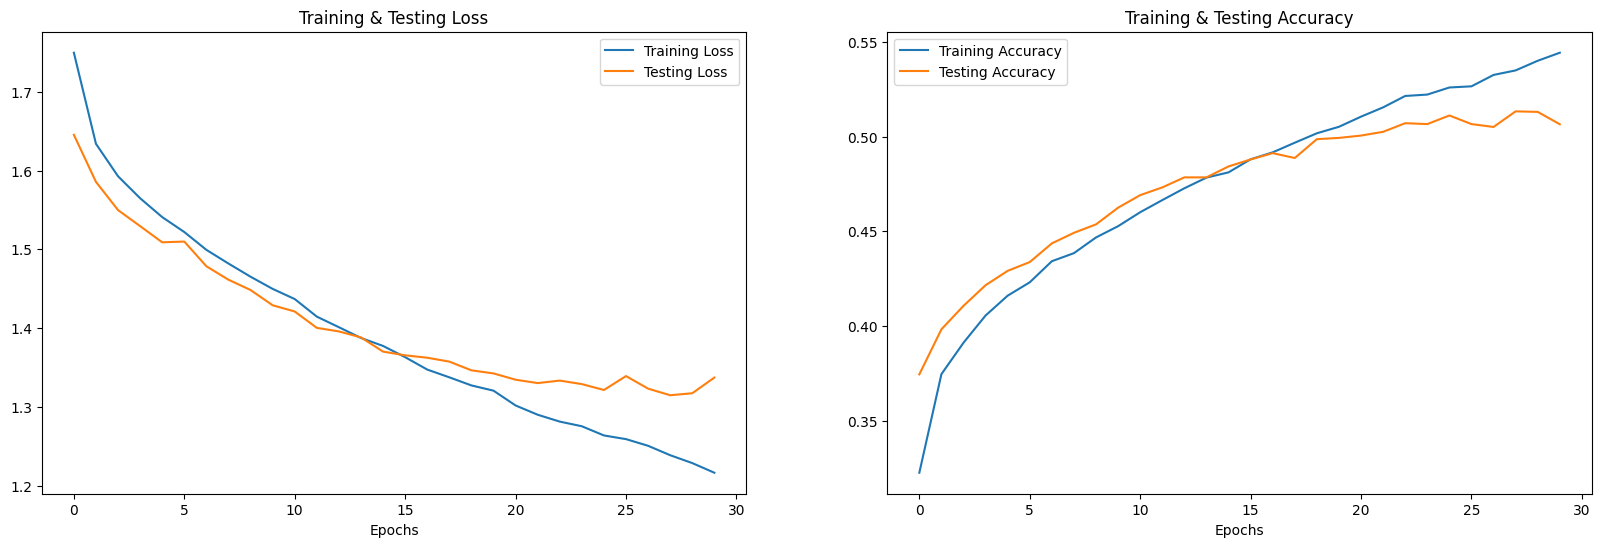

In [63]:
plot_val_vs_loss(history_gloveLstm)

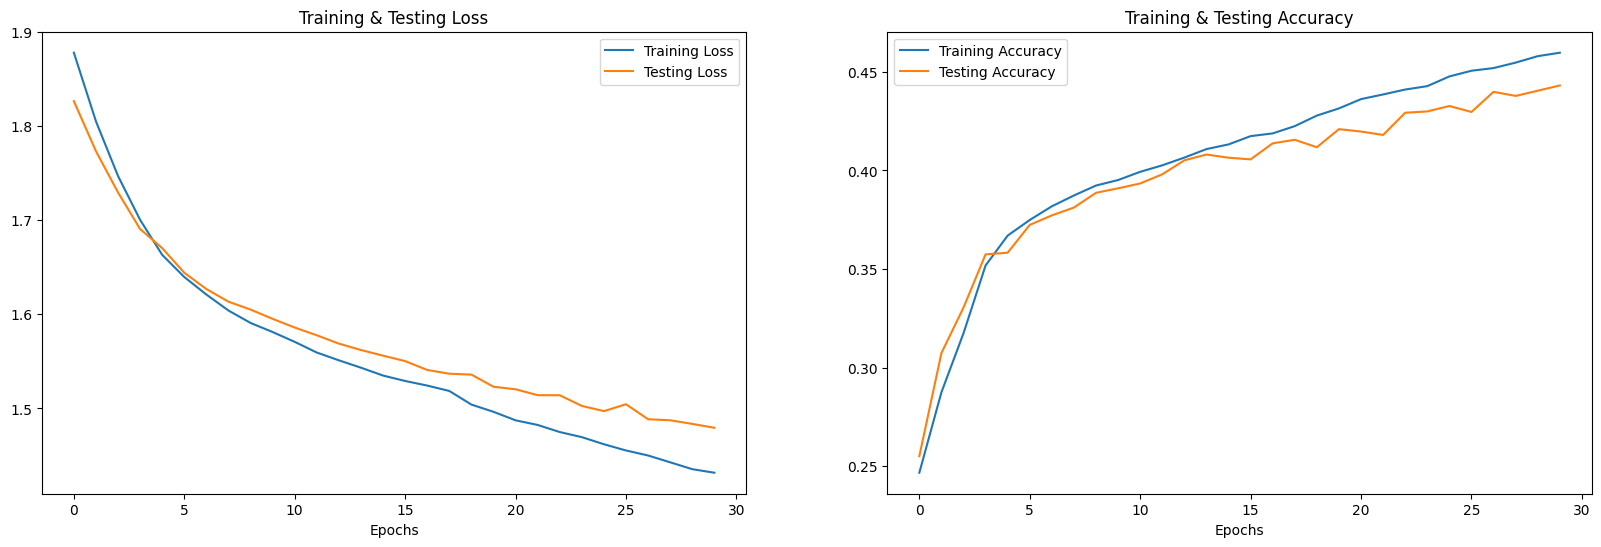

In [64]:
plot_val_vs_loss(history_gloveLstmDo)

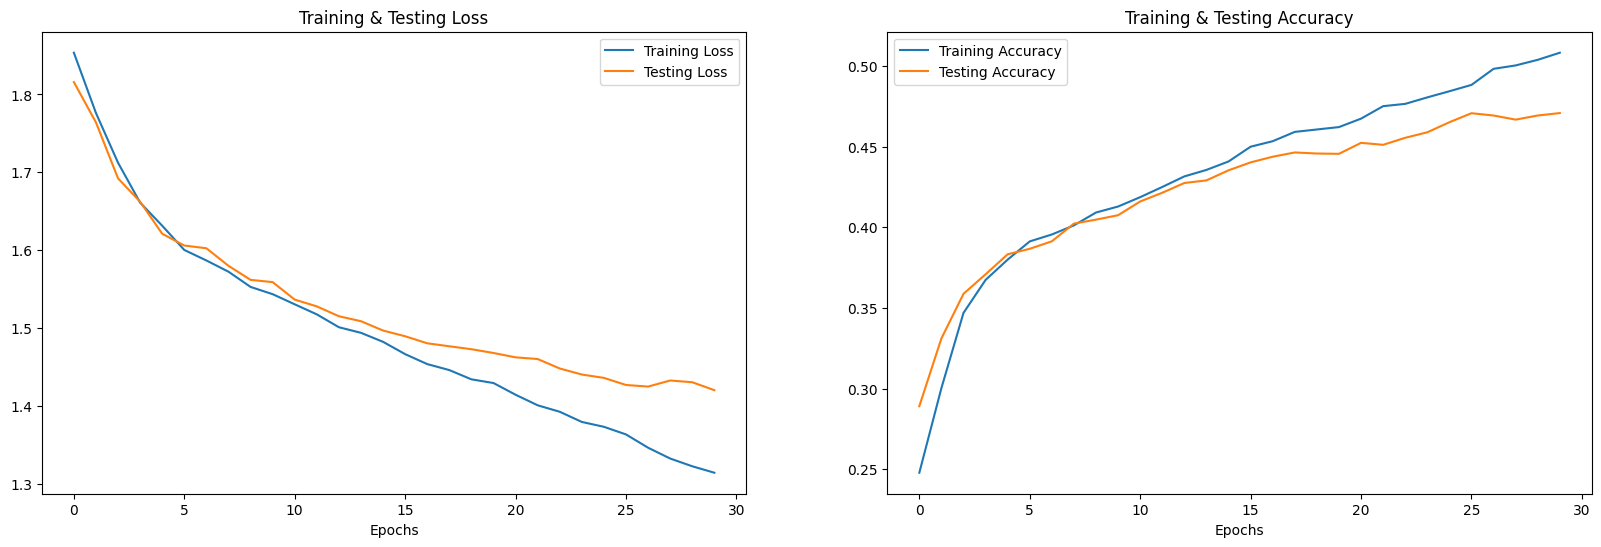

In [65]:
plot_val_vs_loss(history_gloveLstmDoCnn)

#### Heatmap

In [66]:
y_pred_GloveLstm = best_model_gloveLstm.predict(X_test)
y_pred_GloveLstmDo = best_model_gloveLstmDo.predict(X_test)
y_pred_GloveLstmDoCnn = best_model_gloveLstmDoCnn.predict(X_test)

413/413 [==============================] - 2s 3ms/step


In [67]:
y_pred_GloveLstm[0]

array([9.9964547e-01, 3.0191541e-06, 1.8238170e-07, 1.2934458e-06,
       3.4591951e-04, 4.5255641e-07, 3.7157306e-06], dtype=float32)

In [68]:
y_test_np =  np.array(y_test)

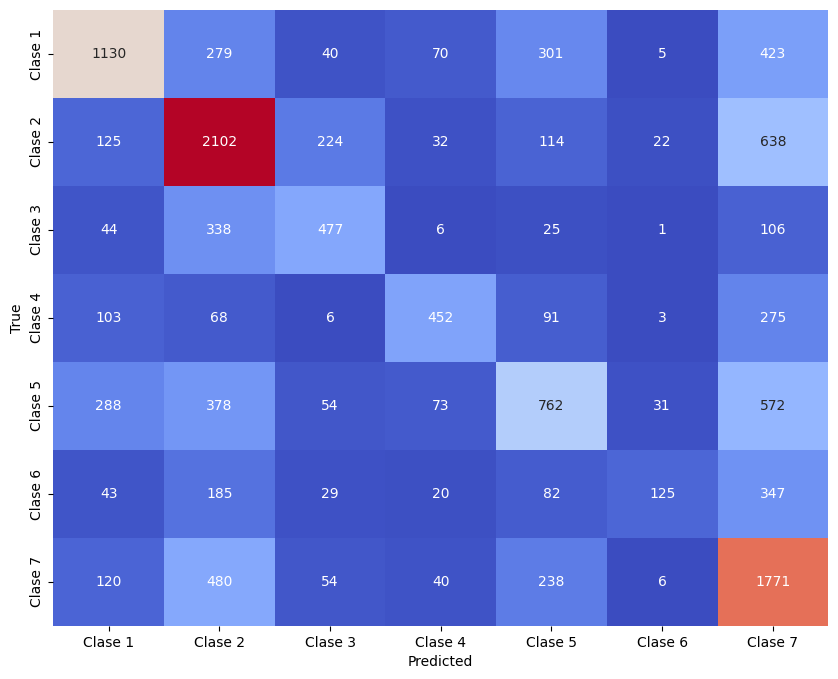

In [69]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_pred, y_test, labels):
    # Realizar predicciones
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Crear el heatmap utilizando Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

labels = ['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5', 'Clase 6', 'Clase 7']
plot_heatmap(y_pred_GloveLstm, y_test_np, labels)

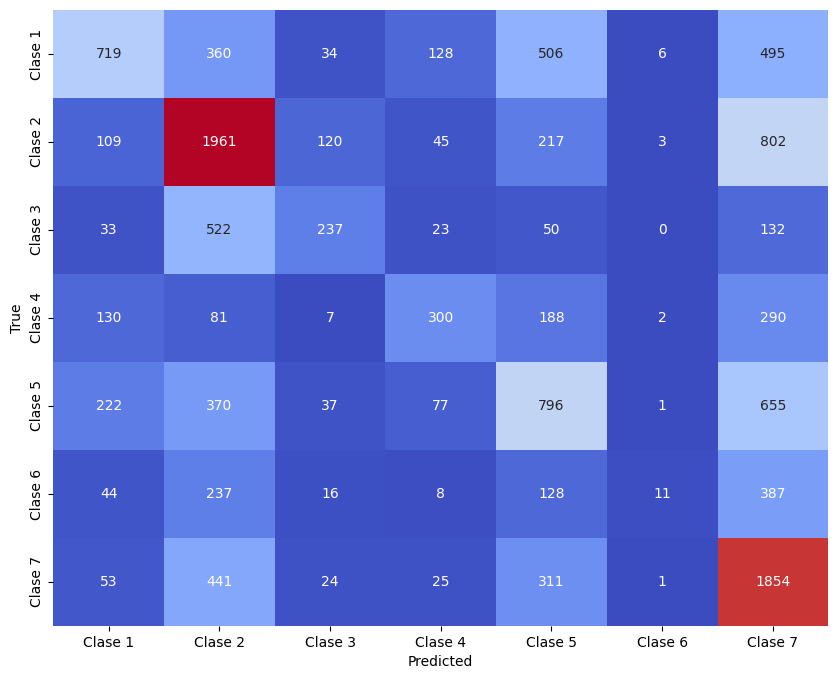

In [70]:
plot_heatmap(y_pred_GloveLstmDo, y_test_np, labels)

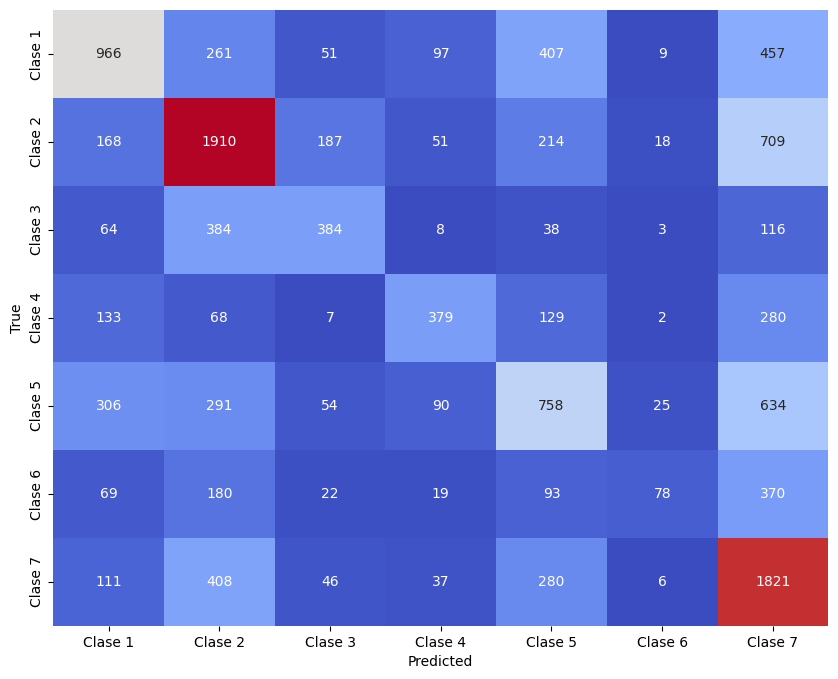

In [71]:
plot_heatmap(y_pred_GloveLstmDoCnn, y_test_np, labels)